In [26]:
######################### Q1 (MLP on Grayscale CIFAR-10) #########################
''' 
Note: 
Beacuse of the "best_mlp_cifar10_gray.pt" file we dont need some parts of traning codes in Q2 .ipnyb file.
- Removed Cell 15: training + early stopping + “best model save” 
- Removed Cell 13: train_one_epoch / validate_one_epoch functions that are not used. 
- Removed Cell 17: train/val plotting because Q2 we have robustness plots.
'''
   



' \nNote: \nBeacuse of the "best_mlp_cifar10_gray.pt" file we dont need some parts of traning codes in Q2 .ipnyb file.\n- Removed Cell 15: training + early stopping + “best model save” \n- Removed Cell 13: train_one_epoch / validate_one_epoch functions that are not used. \n- Removed Cell 17: train/val plotting because Q2 we have robustness plots.\n'

In [55]:
import os                                  
import math                                
import random
import time           
import copy                  
import numpy as np     
import pandas as pd                   
import torch                               # dl framework (allowed)
import torch.nn as nn                      # neural network modules
import torch.optim as optim                # optimizers
from torch.utils.data import DataLoader    # minibatch loading
from torch.utils.data import random_split  # train/val splitting
from torchvision import datasets           # CIFAR-10 dataset loader
from torchvision import transforms         # image transforms
import matplotlib.pyplot as plt     


CKPT_PATH = "best_mlp_cifar10_gray.pt" # Path to saved best model 

In [28]:
SEED = 42                                  # fixed seed for repeatable results
random.seed(SEED)                          # python RNG seed
np.random.seed(SEED)                       # numpy RNG seed
torch.manual_seed(SEED)                    # torch CPU seed
torch.cuda.manual_seed_all(SEED)           # torch GPU seed (if available)
torch.backends.cudnn.deterministic = True  # determinism (may slow a bit)
torch.backends.cudnn.benchmark = False     # determinism

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_cuda = (device.type == "cuda")
print("Using device:", device)

Using device: cpu


In [30]:
# Hyperparameters and constants
BATCH_SIZE = 128                 # bigger batch = faster on CPU too (usually fine)
EPOCHS = 20                      
LR = 1e-3                        # Adam için iyi başlangıç
WEIGHT_DECAY = 1e-3              # hafif L2
DROPOUT_P = 0.25                 # 0.30 -> 0.10 (underfit azalır)
TRAIN_RATIO = 0.90               # 45k train / 5k val
PATIENCE = 5                     # early stopping sabrı (val iyileşmezse dur)                  # CIFAR-10 has 10 classes 


In [31]:
# Simple baseline normalization values for grayscale images:
base_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # RGB -> Gray
    transforms.ToTensor(),                        # [0,1], shape (1,32,32)
])

data_root = "./data"
train_full_raw = datasets.CIFAR10(root=data_root, train=True, download=True, transform=base_transform)
test_raw       = datasets.CIFAR10(root=data_root, train=False, download=True, transform=base_transform)


In [32]:
n_total = len(train_full_raw)                      # 50,000
n_train = int(TRAIN_RATIO * n_total)               # 45,000
n_val   = n_total - n_train                        # 5,000

train_raw, val_raw = random_split(
    train_full_raw,
    lengths=[n_train, n_val],
    generator=torch.Generator().manual_seed(SEED)
)

print(f"Train size: {len(train_raw)}, Val size: {len(val_raw)}, Test size: {len(test_raw)}")

Train size: 45000, Val size: 5000, Test size: 10000


In [33]:
# Compute mean/std from TRAIN ONLY (grayscale)-
def compute_mean_std_gray(dataset, batch_size=512):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    n_pixels = 0
    sum_ = 0.0
    sum_sq = 0.0
    for x, _ in loader:
        # x shape: (B,1,32,32)
        b = x.size(0)
        x = x.view(b, -1)                    # (B,1024)
        sum_ += x.sum().item()               # tüm piksellerin toplamı
        sum_sq += (x * x).sum().item()       # kareler toplamı
        n_pixels += x.numel()                # toplam piksel sayısı
    mean = sum_ / n_pixels
    var = (sum_sq / n_pixels) - (mean * mean)
    std = (var ** 0.5) if var > 0 else 1.0
    return mean, std

gray_mean, gray_std = compute_mean_std_gray(train_raw)
print(f"Computed Gray Mean: {gray_mean:.6f}, Gray Std: {gray_std:.6f}")


Computed Gray Mean: 0.481058, Gray Std: 0.239243


In [34]:
# Create final normalized datasets
norm_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((gray_mean,), (gray_std,)),  # gerçek mean/std
])

# random_split Subset döndürür; asıl dataset objesinin transform'unu değiştirebiliriz:
train_raw.dataset.transform = norm_transform
val_raw.dataset.transform   = norm_transform
test_raw.transform          = norm_transform


In [35]:
# If we have GPU available, pin_memory should be True.
pin = use_cuda

# persistent_workers sadece num_workers>0 ise kullanılabilir.
# Windows'ta epoch arası worker restart maliyetini azaltır.
num_workers = 2  # stabil ise 2 iyi, sorun çıkarsa 0'a çekebilirsin
persist = (num_workers > 0)

train_loader = DataLoader(
    train_raw, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=num_workers, pin_memory=pin,
    persistent_workers=persist
)
val_loader = DataLoader(
    val_raw, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=num_workers, pin_memory=pin,
    persistent_workers=persist
)
test_loader = DataLoader(
    test_raw, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=num_workers, pin_memory=pin,
    persistent_workers=persist
)

In [36]:
# A Class for MLP Feedforward Neural Network)
class MLP(nn.Module):
    def __init__(self, dropout_p=0.1, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(32*32, 1024),     # daha geniş ilk katman
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(dropout_p),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_p),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_p),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),       
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            # Çıkış Katmanı
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # x: (B,1,32,32) -> flatten
        x = x.view(x.size(0), -1)
        return self.net(x)

model = MLP(dropout_p=DROPOUT_P, num_classes=10).to(device)
print(model)

MLP(
  (net): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.25, inplace=False)
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.25, inplace=False)
    (12): Linear(in_features=256, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.25, inplace=False)
    (16): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [37]:
# Loss function + Optimizer + Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Val loss durursa LR düşür (çok işe yarar)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3)



In [38]:
# Utility: Accuracy computation
def accuracy_from_logits(logits, y):
    pred = torch.argmax(logits, dim=1)
    return (pred == y).float().mean().item()

In [39]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss = 0.0
    total_acc  = 0.0
    n = 0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = model(x)
        loss = criterion(logits, y)

        bs = y.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_from_logits(logits, y) * bs
        n += bs

    return total_loss / n, total_acc / n

In [ ]:
################### Q2 (Adversarial Attacks) ###################### 
assert os.path.exists(CKPT_PATH), f"Checkpoint not found: {CKPT_PATH}"

# Model Load for evaluation
model = MLP(dropout_p=DROPOUT_P, num_classes=10).to(device)  # Q1 ile aynı init
state = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(torch.load(CKPT_PATH, map_location=device))
model.eval()

# Evaluate on clean test data
base_loss, base_acc = evaluate(model, test_loader)
base_miscls = 1.0 - base_acc
print(f"BASELINE (clean test) | Acc: {base_acc*100:.2f}% | Misclass: {base_miscls*100:.2f}%")


BASELINE (clean test) | Acc: 47.02% | Misclass: 52.98%


In [41]:
@torch.no_grad()
def evaluate_with_input_attack(model, loader, attack_fn, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total, correct = 0, 0
    loss_sum = 0.0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        x_att = attack_fn(x)
        logits = model(x_att)
        loss = criterion(logits, y)

        loss_sum += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    acc = correct / total
    return (loss_sum / total), acc

In [42]:
# normalize / unnormalize functions for our grayscale images
def unnormalize_gray(x_norm, mean, std):
    # x_norm: normalized tensor
    return x_norm * std + mean

def normalize_gray(x_01, mean, std):
    return (x_01 - mean) / std

In [43]:
# Here is the Pixel Gauss Fuzzing (PGF) function for attacks 
# In hw2.docs we are given μ=0,δ=0.8; parameters so we set default values accordingly.
# Function converts normalized input to pixel space, 
# adds noise to randomly selected pixels and normalizes back basically.
def pgf_pixel_gauss_fuzzing(x_norm, mu=0.0, delta=0.8, p_select=0.10, mean=None, std=None):
   
    assert mean is not None and std is not None, "mean/std must be provided"
    # normalized -> pixel space in range of [0,1]
    x_01 = unnormalize_gray(x_norm, mean, std).clamp(0.0, 1.0)

    # random pixel mask we used .rand_like for same shape as input
    mask = (torch.rand_like(x_01) < p_select).float()

    noise = torch.randn_like(x_01) * delta + mu
    x_fuzz = (x_01 + mask * noise).clamp(0.0, 1.0)

    # pixel space -> normalized
    return normalize_gray(x_fuzz, mean, std)

In [45]:
# PDG Attack Evaluation & Experiments 
# We included the hw2's suggested mu & delta values, and more.
mu_grid    = [0.0, 0.1, -0.1]          
delta_grid = [0.2, 0.5, 0.8, 1.0]      
p_select_grid = [0.05, 0.10, 0.20]     

results_pgf = []

for psel in p_select_grid:
    for mu in mu_grid:
        for delta in delta_grid:
            loss_att, acc_att = evaluate_with_input_attack(
                model,
                test_loader,
                attack_fn=lambda t, mu=mu, delta=delta, psel=psel: pgf_pixel_gauss_fuzzing(
                    t, mu=mu, delta=delta, p_select=psel, mean=gray_mean, std=gray_std
                ),
                device=device
            )
            miscls = 1.0 - acc_att
            results_pgf.append({
                "attack": "PGF",
                "p_select": psel,
                "mu": mu,
                "delta": delta,
                "test_acc": acc_att,
                "misclass": miscls
            })
            print(f"PGF | p={psel:.2f} mu={mu:+.2f} delta={delta:.2f} | Acc={acc_att*100:.2f}% | Misclass={miscls*100:.2f}%")

df_pgf = pd.DataFrame(results_pgf).sort_values(["p_select", "mu", "delta"]).reset_index(drop=True)
df_pgf.head()

PGF | p=0.05 mu=+0.00 delta=0.20 | Acc=46.78% | Misclass=53.22%
PGF | p=0.05 mu=+0.00 delta=0.50 | Acc=46.59% | Misclass=53.41%
PGF | p=0.05 mu=+0.00 delta=0.80 | Acc=46.40% | Misclass=53.60%
PGF | p=0.05 mu=+0.00 delta=1.00 | Acc=46.07% | Misclass=53.93%
PGF | p=0.05 mu=+0.10 delta=0.20 | Acc=46.79% | Misclass=53.21%
PGF | p=0.05 mu=+0.10 delta=0.50 | Acc=46.72% | Misclass=53.28%
PGF | p=0.05 mu=+0.10 delta=0.80 | Acc=46.56% | Misclass=53.44%
PGF | p=0.05 mu=+0.10 delta=1.00 | Acc=46.10% | Misclass=53.90%
PGF | p=0.05 mu=-0.10 delta=0.20 | Acc=46.99% | Misclass=53.01%
PGF | p=0.05 mu=-0.10 delta=0.50 | Acc=46.61% | Misclass=53.39%
PGF | p=0.05 mu=-0.10 delta=0.80 | Acc=46.54% | Misclass=53.46%
PGF | p=0.05 mu=-0.10 delta=1.00 | Acc=46.52% | Misclass=53.48%
PGF | p=0.10 mu=+0.00 delta=0.20 | Acc=46.85% | Misclass=53.15%
PGF | p=0.10 mu=+0.00 delta=0.50 | Acc=45.80% | Misclass=54.20%
PGF | p=0.10 mu=+0.00 delta=0.80 | Acc=45.76% | Misclass=54.24%
PGF | p=0.10 mu=+0.00 delta=1.00 | Acc=4

,attack,p_select,mu,delta,test_acc,misclass
0,PGF,0.05,-0.1,0.2,0.4699,0.5301
1,PGF,0.05,-0.1,0.5,0.4661,0.5339
2,PGF,0.05,-0.1,0.8,0.4654,0.5346
3,PGF,0.05,-0.1,1.0,0.4652,0.5348
4,PGF,0.05,0.0,0.2,0.4678,0.5322


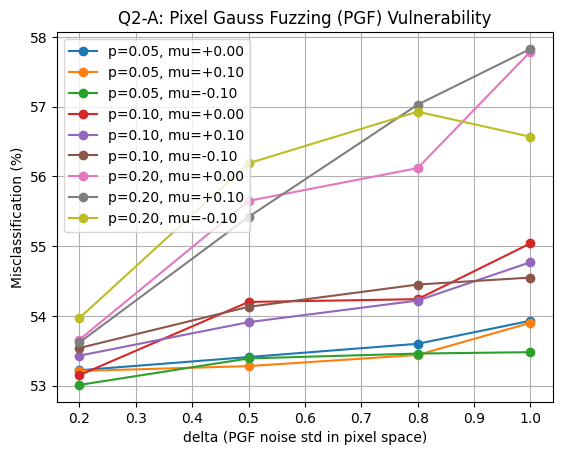

In [47]:
# Plot misclassification vs delta for each mu and p_select
plt.figure()
for psel in p_select_grid:
    for mu in mu_grid:
        sub = df_pgf[(df_pgf["p_select"] == psel) & (df_pgf["mu"] == mu)].sort_values("delta")
        plt.plot(sub["delta"], sub["misclass"]*100, marker="o", label=f"p={psel:.2f}, mu={mu:+.2f}")
plt.xlabel("delta (PGF noise std in pixel space)")
plt.ylabel("Misclassification (%)")
plt.title("Q2-A: Pixel Gauss Fuzzing (PGF) Vulnerability")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
###### Q2-B Weights Gauss Fuzzing Attacks ######
## Add notes for what we are done 

In [56]:
# Here our Gauss fuzzing on model weights function 
def gauss_fuzz_weights(model, mu=0.0, delta=0.1):
    """
    Gauss fuzzing on model weights:
    Adds Gaussian noise N(mu, delta^2) to weights (parameters).
    Returns a deep-copied, fuzzed model (original not modified).
    """
    m = copy.deepcopy(model).to(device)
    m.eval()
    with torch.no_grad():
        for p in m.parameters():
            if p.requires_grad:
                noise = torch.randn_like(p) * delta + mu
                p.add_(noise)
    return m

In [58]:
# Experiments for Weights Gauss Fuzzing
mu_w_grid = [0.0, 0.02, -0.02]          # örnek
delta_w_grid = [0.03, 0.05, 0.10, 0.20] # delta=0.10 mutlaka içeride

results_w = []

for mu in mu_w_grid:
    for delta in delta_w_grid:
        m_fuzz = gauss_fuzz_weights(model, mu=mu, delta=delta)
        loss_f, acc_f = evaluate(m_fuzz, test_loader)
        miscls = 1.0 - acc_f
        results_w.append({
            "attack": "Weight-Gauss",
            "mu": mu,
            "delta": delta,
            "test_acc": acc_f,
            "misclass": miscls
        })
        print(f"WEIGHT | mu={mu:+.2f} delta={delta:.2f} | Acc={acc_f*100:.2f}% | Misclass={miscls*100:.2f}%")

df_w = pd.DataFrame(results_w).sort_values(["mu", "delta"]).reset_index(drop=True)
df_w.head()

WEIGHT | mu=+0.00 delta=0.03 | Acc=9.65% | Misclass=90.35%
WEIGHT | mu=+0.00 delta=0.05 | Acc=10.17% | Misclass=89.83%
WEIGHT | mu=+0.00 delta=0.10 | Acc=8.73% | Misclass=91.27%
WEIGHT | mu=+0.00 delta=0.20 | Acc=9.56% | Misclass=90.44%
WEIGHT | mu=+0.02 delta=0.03 | Acc=10.00% | Misclass=90.00%
WEIGHT | mu=+0.02 delta=0.05 | Acc=10.00% | Misclass=90.00%
WEIGHT | mu=+0.02 delta=0.10 | Acc=10.00% | Misclass=90.00%
WEIGHT | mu=+0.02 delta=0.20 | Acc=11.26% | Misclass=88.74%
WEIGHT | mu=-0.02 delta=0.03 | Acc=9.96% | Misclass=90.04%
WEIGHT | mu=-0.02 delta=0.05 | Acc=7.74% | Misclass=92.26%
WEIGHT | mu=-0.02 delta=0.10 | Acc=9.68% | Misclass=90.32%
WEIGHT | mu=-0.02 delta=0.20 | Acc=8.88% | Misclass=91.12%


,attack,mu,delta,test_acc,misclass
0,Weight-Gauss,-0.02,0.03,0.0996,0.9004
1,Weight-Gauss,-0.02,0.05,0.0774,0.9226
2,Weight-Gauss,-0.02,0.10,0.0968,0.9032
3,Weight-Gauss,-0.02,0.20,0.0888,0.9112
4,Weight-Gauss,0.00,0.03,0.0965,0.9035


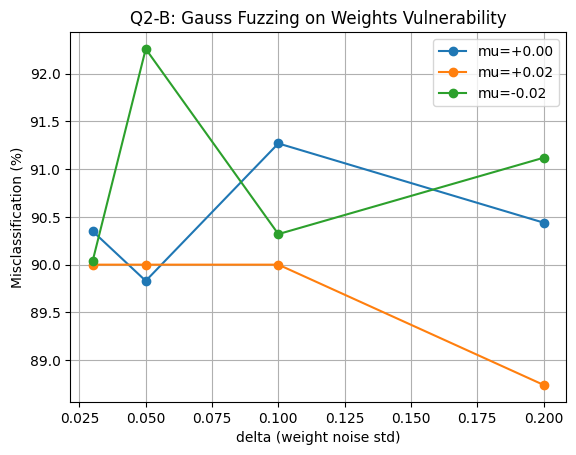

In [59]:
# Plot misclassification and delta for each mu using matplotlib
plt.figure()
for mu in mu_w_grid:
    sub = df_w[df_w["mu"] == mu].sort_values("delta")
    plt.plot(sub["delta"], sub["misclass"]*100, marker="o", label=f"mu={mu:+.2f}")
plt.xlabel("delta (weight noise std)")
plt.ylabel("Misclassification (%)")
plt.title("Q2-B: Gauss Fuzzing on Weights Vulnerability")
plt.grid(True)
plt.legend()
plt.show()


In [60]:
# Vulnerability Summary Table
summary = []

summary.append({
    "scenario": "Baseline (clean)",
    "config": "-",
    "misclass_%": base_miscls * 100
})

# PGF: mu=0, delta=0.8 (choose a reasonable p_select, we report with p_select too)
init_p = 0.10
row_init_pgf = df_pgf[(df_pgf["p_select"]==init_p) & (df_pgf["mu"]==0.0) & (df_pgf["delta"]==0.8)]
if len(row_init_pgf) == 1:
    summary.append({
        "scenario": "PGF initial",
        "config": f"p_select={init_p}, mu=0, delta=0.8",
        "misclass_%": float(row_init_pgf["misclass"].iloc[0] * 100)
    })

# Weight initial: mu=0, delta=0.1
row_init_w = df_w[(df_w["mu"]==0.0) & (df_w["delta"]==0.10)]
if len(row_init_w) == 1:
    summary.append({
        "scenario": "Weight-Gauss initial",
        "config": "mu=0, delta=0.1",
        "misclass_%": float(row_init_w["misclass"].iloc[0] * 100)
    })

df_summary = pd.DataFrame(summary)
df_summary


,scenario,config,misclass_%
0,Baseline (clean),-,52.98
1,PGF initial,"p_select=0.1, mu=0, delta=0.8",54.24
2,Weight-Gauss initial,"mu=0, delta=0.1",91.27


In [ ]:
# Ek olarak CNN ile de bir model olusturup 
# PFG ve weights Gauss Fuzzing saldırılarında daha dayanıklı oldugun gosterelim.
# Burada hem rapora ekleriz model karşılaştırması olarakta guclu durur bence